In [1]:
#Import library pandas
import pandas as pd



In [3]:
#Read data
df = pd.read_excel('vnm_data.xlsx') 

# Show all data
df.head

<bound method NDFrame.head of            Date       Open       High        Low      Close  Volume  \
0    2009-08-14  20.685434  20.708436  19.673397  19.949408       0   
1    2009-08-17  19.972403  22.594500  19.320714  19.343714       0   
2    2009-08-18  20.693099  20.693099  19.566058  19.742397       0   
3    2009-08-19  19.803735  20.118080  19.604394  20.033743       0   
4    2009-08-20  20.248418  20.953778  20.240751  20.677767       0   
...         ...        ...        ...        ...        ...     ...   
3896 2025-02-10  11.400000  11.430000  11.360000  11.400000  435700   
3897 2025-02-11  11.340000  11.370000  11.320000  11.340000  237200   
3898 2025-02-12  11.290000  11.350000  11.280000  11.330000  193100   
3899 2025-02-13  11.400000  11.520000  11.390000  11.490000  366100   
3900 2025-02-14  11.500000  11.500000  11.440000  11.480000  182200   

      Dividends  Stock Splits  Capital Gains  
0           0.0             0              0  
1           0.0        

In [5]:
# delete columns
df = df.drop(columns=["Dividends", "Stock Splits", "Capital Gains"])


In [7]:
#Check the current column
print(df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [15]:
#Create feature tomorrow
df["Tomorrow"]=df["Close"].shift(-1)
print(df)

           Date       Open       High        Low      Close  Volume   Tomorrow
0    2009-08-14  20.685434  20.708436  19.673397  19.949408       0  19.343714
1    2009-08-17  19.972403  22.594500  19.320714  19.343714       0  19.742397
2    2009-08-18  20.693099  20.693099  19.566058  19.742397       0  20.033743
3    2009-08-19  19.803735  20.118080  19.604394  20.033743       0  20.677767
4    2009-08-20  20.248418  20.953778  20.240751  20.677767       0  21.061110
...         ...        ...        ...        ...        ...     ...        ...
3896 2025-02-10  11.400000  11.430000  11.360000  11.400000  435700  11.340000
3897 2025-02-11  11.340000  11.370000  11.320000  11.340000  237200  11.330000
3898 2025-02-12  11.290000  11.350000  11.280000  11.330000  193100  11.490000
3899 2025-02-13  11.400000  11.520000  11.390000  11.490000  366100  11.480000
3900 2025-02-14  11.500000  11.500000  11.440000  11.480000  182200        NaN

[3901 rows x 7 columns]


In [17]:
#Goal: Tomorrow's price must be higher than today's price.
df["target"]=(df["Close"]<df["Tomorrow"]).astype(int)
print(df)

           Date       Open       High        Low      Close  Volume  \
0    2009-08-14  20.685434  20.708436  19.673397  19.949408       0   
1    2009-08-17  19.972403  22.594500  19.320714  19.343714       0   
2    2009-08-18  20.693099  20.693099  19.566058  19.742397       0   
3    2009-08-19  19.803735  20.118080  19.604394  20.033743       0   
4    2009-08-20  20.248418  20.953778  20.240751  20.677767       0   
...         ...        ...        ...        ...        ...     ...   
3896 2025-02-10  11.400000  11.430000  11.360000  11.400000  435700   
3897 2025-02-11  11.340000  11.370000  11.320000  11.340000  237200   
3898 2025-02-12  11.290000  11.350000  11.280000  11.330000  193100   
3899 2025-02-13  11.400000  11.520000  11.390000  11.490000  366100   
3900 2025-02-14  11.500000  11.500000  11.440000  11.480000  182200   

       Tomorrow  target  
0     19.343714       0  
1     19.742397       1  
2     20.033743       1  
3     20.677767       1  
4     21.061110  

In [ ]:
#**Only use data from the year 2010 onwards.**
#df=df.loc["2010-01-01":].copy() # tránh nhận đc cài đặt pandas có cảnh báo copy
#print(df)
#print(df.columns)

In [19]:
#Tranning version-1
from sklearn.ensemble import RandomForestClassifier #có thể chống overfit
model= RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
train = df.iloc[:-100]
test = df.iloc[-100:]
predictors=['Open','High','Low','Close','Volume']
model.fit(train[predictors],train['target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [21]:
# Check the accuracy of the model version-1
from sklearn.metrics import precision_score
preds = model.predict(test[predictors])

preds = pd.Series(preds, index=test.index)
precision_score(test['target'],preds)

0.41509433962264153

<Axes: >

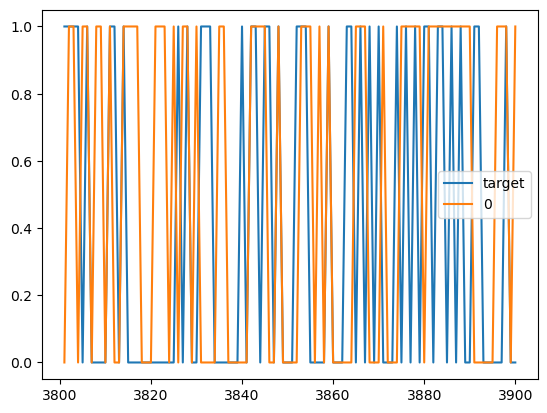

In [23]:
#**Plot the prediction chart: comparing predicted values with actual values.**
combined= pd.concat([test['target'], preds], axis=1)
combined.plot()

In [23]:
#Create predict function
def predict(train, test, predictors, model):
    model.fit(train[predictors],train['target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined=pd.concat([test['target'],preds], axis=1)
    return combined

In [25]:
#Create backtest function
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions =[]

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions=predict(train,test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [27]:
predictions = backtest(df, model, predictors)

In [28]:
# Check the accuracy - Version 2
precision_score(predictions['target'],predictions['Predictions'])

0.50480109739369

In [31]:
#Add features to the DataFrame.
horizons = [2, 5, 60, 250, 500]
new_predictors = []

for horizon in horizons:
    rolling_averages = df.select_dtypes(include=["number"]).rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    df[trend_column] = df["target"].shift(1).rolling(horizon).sum()

    new_predictors += [ratio_column, trend_column]

           Date       Open       High        Low      Close  Volume  \
0    2009-08-14  20.685434  20.708436  19.673397  19.949408       0   
1    2009-08-17  19.972403  22.594500  19.320714  19.343714       0   
2    2009-08-18  20.693099  20.693099  19.566058  19.742397       0   
3    2009-08-19  19.803735  20.118080  19.604394  20.033743       0   
4    2009-08-20  20.248418  20.953778  20.240751  20.677767       0   
...         ...        ...        ...        ...        ...     ...   
3896 2025-02-10  11.400000  11.430000  11.360000  11.400000  435700   
3897 2025-02-11  11.340000  11.370000  11.320000  11.340000  237200   
3898 2025-02-12  11.290000  11.350000  11.280000  11.330000  193100   
3899 2025-02-13  11.400000  11.520000  11.390000  11.490000  366100   
3900 2025-02-14  11.500000  11.500000  11.440000  11.480000  182200   

       Tomorrow  target  Close_Ratio_2  Trend_2  Close_Ratio_5  Trend_5  \
0     19.343714       0            NaN      NaN            NaN      NaN 

In [61]:
#Remove columns containing NaN values.
#df=df.dropna()

In [33]:
#Fill NaN values in the DataFrame with the mean value.
df.fillna(df.mean(), inplace=True)

In [37]:
model= RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [35]:
print(df)

           Date       Open       High        Low      Close  Volume  \
0    2009-08-14  20.685434  20.708436  19.673397  19.949408       0   
1    2009-08-17  19.972403  22.594500  19.320714  19.343714       0   
2    2009-08-18  20.693099  20.693099  19.566058  19.742397       0   
3    2009-08-19  19.803735  20.118080  19.604394  20.033743       0   
4    2009-08-20  20.248418  20.953778  20.240751  20.677767       0   
...         ...        ...        ...        ...        ...     ...   
3896 2025-02-10  11.400000  11.430000  11.360000  11.400000  435700   
3897 2025-02-11  11.340000  11.370000  11.320000  11.340000  237200   
3898 2025-02-12  11.290000  11.350000  11.280000  11.330000  193100   
3899 2025-02-13  11.400000  11.520000  11.390000  11.490000  366100   
3900 2025-02-14  11.500000  11.500000  11.440000  11.480000  182200   

       Tomorrow  target  Close_Ratio_2   Trend_2  Close_Ratio_5   Trend_5  \
0     19.343714       0       0.999929  0.986407       0.999766  2.465

In [39]:
predictions = backtest(df, model, new_predictors)

In [40]:
predictions["Predictions"].value_counts()

Predictions
0    720
1    681
Name: count, dtype: int64

In [43]:
#Checking the acurracy of model
precision_score(predictions["target"], predictions["Predictions"])

0.5066079295154186

In [49]:
#kiểm tra mức độ tương quan của các feature với target:
df[new_predictors + ["target"]].corr()["target"].sort_values(ascending=False)

target             1.000000
Trend_250          0.014135
Trend_60           0.013225
Close_Ratio_250    0.010576
Close_Ratio_500   -0.000181
Trend_5           -0.004454
Close_Ratio_60    -0.013986
Trend_2           -0.019769
Trend_500         -0.023169
Close_Ratio_5     -0.040183
Close_Ratio_2     -0.049373
Name: target, dtype: float64